In [1]:
%load_ext autoreload
%autoreload 2 

%matplotlib inline

# Matmul and Building a Neural Net in PyTorch - Understanding the Building Blocks

## Matrix Multiplication Refresher

Matrix multiplications are the beating heart of Deep Learning; the so-called magic trick. Before building our Neural Net, using PyTorch, lets quickly run through a refresher of matrix multiplications using various methodologies to achieve the same results and then compare their performance. 

In [2]:
# Importing Libraries
from pathlib import Path
from IPython.core.debugger import set_trace
from fastai import datasets
import pickle, gzip, math, matplotlib as mpl
import matplotlib.pyplot as plt
import torch
from torch import tensor

In [3]:
# URL for MNIST dataset
MNIST_URL = "http://deeplearning.net/data/mnist/mnist.pkl"

In [4]:
# Downloading dataset
path = datasets.download_data(MNIST_URL, ext='.gz')
path

PosixPath('/home/bilal/.fastai/data/mnist.pkl.gz')

In [5]:
# Loading training and validation sets directly from the pickle file
with gzip.open(path, 'rb') as f:
    ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')

In [6]:
# Mapping the datasets into tensors and printing relevant details
x_train, y_train, x_valid, y_valid = map(tensor, (x_train, y_train, x_valid, y_valid))

n, c = x_train.shape

x_train, x_train.shape, y_train, y_train.shape, y_train .min(), y_train.max()

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 torch.Size([50000, 784]),
 tensor([5, 0, 4,  ..., 8, 4, 8]),
 torch.Size([50000]),
 tensor(0),
 tensor(9))

In [7]:
# Creating a testing function to verify details before calculations
import operator

def test(a, b, cmp, cname=None):
    if cname is None: 
        cname = cmp.__name__
    assert cmp(a, b), f"{cname}:\n{a}\n{b}"
        

def test_eq(a, b):
    test(a, b, operator.eq, '==')

In [8]:
# Running tests
assert n == y_train.shape[0] == 50000
# Testing functions
test_eq(c, 28*28) 
test_eq(y_train.min(), 0)
test_eq(y_train.max(), 9)

In [9]:
# Setting colormap for MNIST
mpl.rcParams['image.cmap'] = 'gray'

In [10]:
# Testing image output in a 28x28 format
img = x_train[0]
img.view(28, 28).type()

'torch.FloatTensor'

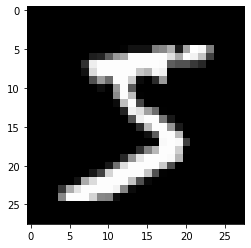

In [11]:
plt.imshow(img.view((28, 28)));

### Standard Python

In [12]:
# Initializing weights and a bias vector
weights = torch.randn(784, 10)
bias = torch.zeros(10)

Doing a matrix multiplication using Python's for loops to get a sense of our slowest results:

In [13]:
# Creating function for matrix multiplication
def matmul(a, b):
    a_row, a_col = a.shape
    b_row, b_col = b.shape
    assert a_col == b_row
    c = torch.zeros(a_row, b_col)
    for i in range(a_row):
        for j in range(b_col):
            for k in range(a_col): # can be swapped with b_row
                c[i, j] += a[i, k] * b[k, j]
    return c

In [14]:
x_valid.shape

torch.Size([10000, 784])

In [15]:
# For m1, we will pick just the first 6 rows, to save time since
# matmul in python is SUPER SLOW!
m1 = x_valid[:5]
m2 = weights

In [16]:
# Getting the shape of our two tensors
m1.shape, m2.shape

(torch.Size([5, 784]), torch.Size([784, 10]))

In [17]:
# Running our first matrix multiplication 
%time t1 = matmul(m1, m2)

CPU times: user 606 ms, sys: 1.12 ms, total: 607 ms
Wall time: 524 ms


In [18]:
t1.shape

torch.Size([5, 10])

Now that we have established our baseline. Let's try to speed the whole process up by 50,000 times.

#### Element-wise Matmul

In [19]:
# Refactoring the matmul function for element wise operations
def matmul(a, b):
    a_row, a_col = a.shape
    b_row, b_col = b.shape
    assert a_col == b_row
    c = torch.zeros(a_row, b_col)
    for i in range(a_row):
        for j in range(b_col):
            c[i, j] = (a[i, :] * b[:, j]).sum()
    return c

In [20]:
# Running 10 loops of the matmul operation
%timeit -n 10 _= matmul(m1, m2)

838 µs ± 161 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


This simple refactoring has resulted in a performance boost of:

In [21]:
798 / 5

159.6

In [22]:
# If we were to export this
# Running the torch.allclose method to test whether two elements
# are elements-wise equal to within a tolerance
def near(a, b):
    return torch.allclose(a, b, rtol=1e-3, atol=1e-5)

def test_near(a, b): 
    test(a, b, near)

In [23]:
# Testing with our first matmul tensor
test_near(t1, matmul(m1, m2))

### Broadcasting

Just to get a sense of what the unsqueeze() method will do, let's run a few tensor operations:

In [24]:
c = tensor([10., 20., 30.])
c, c.shape

(tensor([10., 20., 30.]), torch.Size([3]))

In [25]:
c.unsqueeze(0), c.shape

(tensor([[10., 20., 30.]]), torch.Size([3]))

In [26]:
c.unsqueeze(1), c.shape

(tensor([[10.],
         [20.],
         [30.]]),
 torch.Size([3]))

In [27]:
c.unsqueeze(-1), c.shape

(tensor([[10.],
         [20.],
         [30.]]),
 torch.Size([3]))

In [28]:
c[None].shape

torch.Size([1, 3])

In [29]:
c[:, None].shape

torch.Size([3, 1])

In [30]:
# Now we will leverage the performance of C
# with broadcasting to improve matmul's performance
def matmul(a, b):
    a_row, a_col = a.shape
    b_row, b_col = b.shape
    assert a_col == b_row
    c = torch.zeros(a_row, b_col)
    for i in range(a_row):
        c[i] = ((a[i].unsqueeze(-1) * b).sum(dim=0))
    return c

In [31]:
%timeit -n 10 _= matmul(m1, m2)

213 µs ± 53.1 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [32]:
810000/181

4475.138121546961

As we can see from the results above, refactoring the matmul() method using broadcasting gives us a performance increase by a whopping 4500x! 

But this can be improved further with PyTorch's inbuilt implementation of the Einstein Summation and the operator used for matrix multiplications. 

### Einstein Summation and PyTorch Operator

The lesson NB introduces EinSum as:

Einstein summation (`einsum`) is a compact representation for combining products and sums in a general way. From the numpy docs:

"The subscripts string is a comma-separated list of subscript labels, where each label refers to a dimension of the corresponding operand. Whenever a label is repeated it is summed, so `np.einsum('i,i', a, b)` is equivalent to `np.inner(a,b)`. If a label appears only once, it is not summed, so `np.einsum('i', a)` produces a view of a with no changes."

In [33]:
# Refactoring
def matmul(a, b):
    return torch.einsum('ik, kj->ij', a, b)

In [34]:
%timeit -n 10 _= matmul(m1, m2)

27.5 µs ± 8.14 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [35]:
810000/29.2

27739.72602739726

Performance has now gone up by 27740x!!

The PyTorch operator will give us our best results yet!

In [36]:
%timeit -n 10 t2 = m1.matmul(m2)

5.28 µs ± 3 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [37]:
# The same operation can be run with 
t2 = m1@m2

In [38]:
test_near(t1, t2)

In [39]:
810000/10

81000.0

The final result is an approximate performance increase of **81,000** times.

## Building a Neural Network From Scratch in PyTorch

### Data Prep

In [40]:
# The lesson notebook uses exports from the previous notebooks for
# all its library imports.
# We won't have to do that for now, so proceeding with loading our datasets.
def get_data():
    # Loads MNIST dataset
    path = datasets.download_data(MNIST_URL, ext='.gz')
    with gzip.open(path, 'rb') as file:
        ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(file, encoding='latin-1')
        return map(tensor, (x_train, y_train, x_valid, y_valid))

In [41]:
# Normalizing the data sets using broadcasting
def normalize(x, mean, std):
    return (x - mean) / std

In [42]:
# Loading training and validation datasets
x_train, y_train, x_valid, y_valid = get_data()

In [43]:
# Before initializing our weights and biases, let's take a look
# at the training data's mean and std. dev.
train_mean, train_std = x_train.mean(), x_train.std()
train_mean, train_std

(tensor(0.1304), tensor(0.3073))

In [44]:
# Normalizing the training set and validation set
# Making sure to normalize validation set with the
# training set's mean.
x_train = normalize(x_train, train_mean, train_std)

x_valid = normalize(x_valid, train_mean, train_std)

In [45]:
train_mean, train_std = x_train.mean(), x_train.std()
train_mean, train_std

(tensor(-6.2598e-06), tensor(1.))

In [46]:
# Testing means to within a tolerance range
def test_near_zero(a, tol=1e-3): 
    assert a.abs() < tol
    f"Near zero:{a}"

In [47]:
test_near_zero(x_train.mean())
test_near_zero(1-x_train.std())

In [48]:
# Shape of the matrices 
n, m = x_train.shape
# No. of activations
c= y_train.max()+1
n, m, c

(50000, 784, tensor(10))

### Basic Architecture of the Forward Pass

In [49]:
# Size of a single hidden layer
nh = 50

In [50]:
# Using simplified init
w1 = torch.randn(m, nh) / math.sqrt(m)
b1 = torch.zeros(nh)
w2 = torch.randn(nh, 1) / math.sqrt(nh)
b2 = torch.zeros(1)

In [51]:
# Testing tolerance levels
test_near_zero(w1.mean())
test_near_zero(w1.std() - 1 / math.sqrt(m))

In [52]:
# Checking validation set's means
# mean and std have to be ~ (0, 1)
x_valid.mean(), x_valid.std()

(tensor(-0.0059), tensor(0.9924))

In [53]:
# Creating a linear function for testing
# means
def lin(x, weight, bias):
    return x@weight + bias 

In [54]:
t = lin(x_valid, w1, b1)

In [55]:
t.mean(), t.std()

(tensor(0.0375), tensor(0.9509))

In [56]:
# Function to rectify negative values
def relu(x):
    return x.clamp_min(0.)

In [57]:
# Adding rectifier to the linear function
t = relu(lin(x_valid, w1, b1))

In [58]:
# The result will not be mean, std ~ (0, 1)
# since the rectifier removed all negative
# values
t.mean(), t.std()
# The paper in the link goes into much detail
# regarding this issue 

(tensor(0.3961), tensor(0.5525))

From pytorch docs: `a: the negative slope of the rectifier used after this layer (0 for ReLU by default)`

$$\text{std} = \sqrt{\frac{2}{(1 + a^2) \times \text{fan_in}}}$$

This was introduced in the paper that described the Imagenet-winning approach from *He et al*: [Delving Deep into Rectifiers](https://arxiv.org/abs/1502.01852)

In [59]:
# Using Kaiming / He init for relu
w1 = torch.randn(m , nh) * math.sqrt(2/m)

In [60]:
w1.mean(), w1.std()

(tensor(-0.0002), tensor(0.0503))

In [61]:
# Now that the weight is initalized with he init
# The resulting std is close to one
# However, the mean is still not close to 0
t = relu(lin(x_valid, w1, b1))
t.mean(), t.std()

(tensor(0.5729), tensor(0.8323))

In [62]:
# Checking to see if pytorch's he init
# returns different or similar results
from torch.nn import init

w1 = torch.zeros(m ,nh)
# 'fan_in' and 'fan_in' documentation states
# Choosing 'an_in'preserves the magnitude of the variance 
# of the weights in the forward pass
# 'fan_out' preserves the magnitudes in thebackwards pass.
init.kaiming_normal_(w1, mode='fan_out') 

tensor([[-0.0122,  0.0919,  0.0872,  ...,  0.0343, -0.0835, -0.0183],
        [ 0.0692, -0.0320, -0.0400,  ...,  0.0459,  0.0290, -0.0425],
        [ 0.0103, -0.0218, -0.0194,  ...,  0.0441, -0.0318, -0.0557],
        ...,
        [ 0.0042, -0.0861, -0.0370,  ..., -0.0583, -0.0047,  0.0725],
        [ 0.0496, -0.0133,  0.1142,  ...,  0.0309,  0.0447,  0.0544],
        [-0.0236,  0.0444,  0.0336,  ...,  0.0442, -0.0055, -0.0492]])

In [63]:
init.kaiming_normal_??

Signature: init.kaiming_normal_(tensor, a=0, mode='fan_in', nonlinearity='leaky_relu')
Source:   
def kaiming_normal_(tensor, a=0, mode='fan_in', nonlinearity='leaky_relu'):
    r"""Fills the input `Tensor` with values according to the method
    described in `Delving deep into rectifiers: Surpassing human-level
    performance on ImageNet classification` - He, K. et al. (2015), using a
    normal distribution. The resulting tensor will have values sampled from
    :math:`\mathcal{N}(0, \text{std}^2)` where

    .. math::
        \text{std} = \sqrt{\frac{2}{(1 + a^2) \times \text{fan\_in}}}

    Also known as He initialization.

    Args:
        tensor: an n-dimensional `torch.Tensor`
        a: the negative slope of the rectifier used after this layer (0 for ReLU
            by default)
        mode: either ``'fan_in'`` (default) or ``'fan_out'``. Choosing ``'fan_in'``
            preserves the magnitude of the variance of the weights in the
            forward pass. Choosing ``'fan_

In [64]:
w1.mean(), w1.std(), w1.shape

(tensor(-0.0001), tensor(0.0507), torch.Size([784, 50]))

In [65]:
t = relu(lin(x_valid, w1, b1))

**NOTE**: _The linear layer does not contain a transpose of w1_

In [66]:
# Results are pretty similar to the manual approach
t.mean(), t.std()

(tensor(0.4950), tensor(0.7835))

In [67]:
# Creating a single layer NN
torch.nn.Linear(m, nh).weight.shape

torch.Size([50, 784])

**NOTE:** _PyTorch's version of the linear layer **does** contain a transpose of w1._ 

In [68]:
# Experimenting with a modification in the relu function
# to reduce the mean of the linear function
def relu(x):
    return x.clamp_min(0.) - 0.5

In [69]:
# Retrying initialization
w1 = torch.randn(m, nh) * math.sqrt(2./ m)
t1 = relu(lin(x_valid, w1, b1))
t1.mean(), t1.std()

(tensor(0.1001), tensor(0.8604))

In [70]:
# Function to create our model
def model(x):
    layer1 = lin(x, w1, b1)
    layer2 = relu(layer1)
    layer3 = lin(layer2, w2, b2)
    return layer3

In [71]:
%timeit -n 10 _= model(x_valid)

3.87 ms ± 182 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [72]:
# Testing the output shape of our model
assert model(x_valid).shape == torch.Size([x_valid.shape[0], 1])

### Creating MSE Loss Function for Testing

For testing we will use MSE, instead of Cross Entropy Loss.

In [73]:
def mse(out, targ):
    # Getting rid of unit axis with squeeze
    # Taking care mention the dimension
    # in case there is ever a batch size of size 1
    return (out.squeeze(-1) - targ).pow(2).mean()

In [74]:
# Converting targets to float to calculate the 
# mse
y_train, y_valid = y_train.float(), y_valid.float()

In [75]:
preds = model(x_train)

In [76]:
preds.shape

torch.Size([50000, 1])

In [77]:
# Calculating loss
mse(preds, y_train)

tensor(24.8544)

### Architecture for the Backward Pass and Gradients

Working backwards from our loss calculating layer...

In [78]:
def mse_grad(inp, targ):
    # Gradient loss with respect to output of previous layer
    # storing as an attribute of the input layer 
    inp.g  = 2. * (inp.squeeze() - targ).unsqueeze(-1) / inp.shape[0]

In [79]:
def relu_grad(inp, out):
    # Gradient of relu with respect to input activations
    # out.g becomes the gradient of the next layer
    inp.g = (inp > 0).float() * out.g

In [80]:
def lin_grad(inp, out, w, b):  
    inp.g = out.g @ w.t()
    w.g = (inp.unsqueeze(-1) * out.g.unsqueeze(1)).sum(0)
    b.g = out.g.sum(0)

In [81]:
def forward_and_backward(inp, targ):
    # forward pass
    layer1 = inp @ w1 + b1
    layer2 = relu(layer1)
    out = layer2 @ w2 + b2
    # This loss doesn't appear in the gradients
    # Just so we can print it
    loss = mse(out, targ)
    
    # backward pass
    mse_grad(out, targ)
    lin_grad(layer2, out, w2, b2)
    relu_grad(layer1, layer2)
    lin_grad(inp, layer1, w1, b1)

In [82]:
forward_and_backward(x_train, y_train)

In [83]:
# Cloning the weights and biases of the gradients for testing
w1g = w1.g.clone()
w2g = w2.g.clone()
b1g = b1.g.clone()
b2g = b2.g.clone()
inp_g = x_train.g.clone()

In [84]:
# Using Pytorch autograd to check out results
xt2 = x_train.clone().requires_grad_(True)
w12 = w1.clone().requires_grad_(True)
w22 = w2.clone().requires_grad_(True)
b12 = b1.clone().requires_grad_(True)
b22 = b2.clone().requires_grad_(True)

In [85]:
# Creating a forward pass for testing the values cloned above
def forward(inp, targ):
    layer1 = inp @ w12 + b12
    layer2 = relu(layer1)
    out = layer2 @ w22 + b22
    return mse(out, targ)

In [86]:
# Test loss from the cloned training set
test_loss = forward(xt2, y_train)

In [87]:
test_loss.backward()

In [88]:
# Testing the gradients
test_near(w22.grad, w2g)
test_near(b22.grad, b2g)
test_near(w12.grad, w1g)
test_near(b12.grad, b1g)
test_near(xt2.grad, inp_g)

### Refactoring the Model

This becomes very similar to the PyTorch API.

In [89]:
# Refactored version of the relu layer
class Relu():
    def __call__(self, inp):
        self.inp = inp
        self.out = inp.clamp_min(0.) - 0.5
        return self.out
    
    def backward(self):
        self.inp.g = (self.inp > 0).float() * self.out.g

In [90]:
# Refactored version of the linear layer
class Lin():
    def __init__(self, w, b): 
        self.w = w
        self.b = b
        
    def __call__(self, inp):
        self.inp = inp
        self.out = inp @ self.w + self.b
        return self.out
    
    def backward(self):
        self.inp.g = self.out.g @ self.w.t()
        self.w.g = (self.inp.unsqueeze(-1) * self.out.g.unsqueeze(1)).sum(0)
        self.b.g = self.out.g.sum(0)

In [91]:
# Refactored version of the MSE
class MSE():
    def __call__(self, inp, targ):
        self.inp = inp
        self.targ = targ
        self.out = (inp.squeeze() - targ).pow(2).mean()
        return self.out
    
    def backward(self):
        self.inp.g = 2. * (self.inp.squeeze() - self.targ).unsqueeze(-1) / self.targ.shape[0]

In [92]:
class Model():
    def __init__(self, w1, b1, w2, b2):
        self.layers = [Lin(w1, b1), Relu(), Lin(w2, b2)]
        self.loss = MSE()
        
    def __call__(self, x, targ):
        for l in self.layers:
            x = l(x) # Function composition
        return self.loss(x, targ)
    
    def backward(self):
        self.loss.backward()
        for l in reversed(self.layers):
            l.backward()

In [93]:
# Setting all of our previously initialized gradients to zero
w1.g, b1.g, w2.g, b2.g = [None]*4
# Creating model
model = Model(w1, b1, w2, b2)

In [94]:
%time loss = model(x_train, y_train)

CPU times: user 93.1 ms, sys: 7.16 ms, total: 100 ms
Wall time: 16.6 ms


In [95]:
%time model.backward()

CPU times: user 5.99 s, sys: 2.32 s, total: 8.31 s
Wall time: 1.41 s


In [96]:
# Running tolerance test for gradients
test_near(w2g, w2.g)
test_near(b2g, b2.g)
test_near(w1g, w1.g)
test_near(b1g, b1.g)
test_near(inp_g, x_train.g)

### Creating Module Class to Reduce Code Duplication - with additional refactoring

In [97]:
class Module():
    # This class will factor out all of the duplication
    # and works just like nn.Module
    def __call__(self, *args):
        self.args = args
        self.out = self.forward(*args)
        return self.out
    
    def forward(self):
        raise Exception("Not Implemented")
        
    def backward(self):
        self.bwd(self.out, *self.args)

In [98]:
class Relu(Module):
    def forward(self, inp):
        return inp.clamp_min(0.) - 0.5
    
    def bwd(self, out, inp):
        inp.g = (inp > 0).float() * out.g

In [99]:
class Lin(Module):
    def __init__(self, w, b):
        self.w, self.b = w, b
        
    def forward(self, inp):
        return inp @ self.w + self.b
    
    def bwd(self, out, inp):
        inp.g = out.g @ self.w.t()
        self.w.g = torch.einsum("bi,bj->ij", inp, out.g)
        self.b.g = out.g.sum(0)

In [100]:
class MSE(Module):
    def forward(self, inp, targ):
        return (inp.squeeze() - targ).pow(2).mean()
    
    def bwd(self, out, inp, targ):
        inp.g = 2*(inp.squeeze() - targ).unsqueeze(-1) / targ.shape[0]

In [101]:
class Model():
    def __init__(self):
        self.layers = [Lin(w1, b1), Relu(), Lin(w2, b2)]
        self.loss = MSE()
        
    def __call__(self, x, targ):
        for l in self.layers:
            x = l(x)
        return self.loss(x, targ)
    
    def backward(self):
        self.loss.backward()
        for l in reversed(self.layers):
            l.backward()

In [102]:
# Resetting the gradients
w1.g, b1.g, w2.g, b2.g = [None]*4
model = Model()

In [103]:
%time loss = model(x_train, y_train)

CPU times: user 133 ms, sys: 1.92 ms, total: 135 ms
Wall time: 22.5 ms


In [104]:
%time model.backward()

CPU times: user 280 ms, sys: 80 ms, total: 360 ms
Wall time: 60.1 ms


Our model's performance has increased considerably over the previous refactoring.

### Doing away with einsum()

In [105]:
class Lin(Module):
    def __init__(self, w ,b):
        self.w, self.b = w, b
        
    def forward(self, inp):
        return inp@self.w + self.b
    
    def bwd(self, out, inp):
        inp.g = out.g @ self.w.t()
        self.w.g = inp.t() @ out.g
        self.b.g = out.g.sum(0)

In [106]:
w1.g, b1.g, w2.g, b2.g = [None]*4
model = Model()

In [107]:
%time loss = model(x_train, y_train)

CPU times: user 116 ms, sys: 9.25 ms, total: 126 ms
Wall time: 20.9 ms


In [108]:
%time model.backward()

CPU times: user 260 ms, sys: 94.7 ms, total: 354 ms
Wall time: 59 ms


## Mini-Batches and the Training Loop Using nn.Module

In [109]:
from torch.nn import init
import torch.nn.functional as F
from torch import nn


# Setting output colormap
mpl.rcParams['image.cmap'] = 'gray'

In [110]:
# Reloading data using the method we created earlier
x_train, y_train, x_valid, y_valid = get_data()

In [111]:
# Shape of matrices, number of activations
# and number of hidden layers
n, m = x_train.shape
c = y_train.max() + 1
nh = 50

In [112]:
# Revisiting nn.Module
class Model(nn.Module):
    def __init__(self, n_in, nh, n_out):
        super().__init__()
        self.layers = [nn.Linear(n_in, nh), nn.ReLU(), nn.Linear(nh, n_out)]
        
    def __call__(self, x):
        for l in self.layers:
            x = l(x)
        return x

In [113]:
# Initializing model
model = Model(m, nh, 10)

In [114]:
# Getting predictions
preds = model(x_train)

### Cross Entropy Loss

Previously, we used MSE as our loss function due to expediency. Since this is a classification problem, we will use Cross-Entropy Loss.
 
 We begin by computing the softmax of our activations:
 
 $$\hbox{softmax(x)}_{i} = \frac{e^{x_{i}}}{e^{x_{0}} + e^{x_{1}} + \cdots + e^{x_{n-1}}}$$

or more concisely:

$$\hbox{softmax(x)}_{i} = \frac{e^{x_{i}}}{\sum_{0 \leq j \leq n-1} e^{x_{j}}}$$ 

We will need the log of the softmax when we calculate the loss.

In [115]:
def log_softmax(x):
    return (x.exp() / (x.exp().sum(-1, keepdim=True))).log()

In [116]:
preds_sm = log_softmax(preds)

The cross entropy loss for some target $x$ and some prediction $p(x)$ is given by:

$$ -\sum x\, \log p(x) $$

But since our $x$s are 1-hot encoded, this can be rewritten as $-\log(p_{i})$ where i is the index of the desired target.

In [117]:
# To illustrate the above, let's take 4 target values from  our training
# set.
y_train[:4]

tensor([5, 0, 4, 1])

In [118]:
# Using integer array indexing, we will generate
# loss on these predictions 
preds_sm[[0, 1, 2, 3], [5, 0, 4, 1]]

tensor([-2.2128, -2.2520, -2.2651, -2.2990], grad_fn=<IndexBackward>)

In [119]:
# Another interpretation
def neg_ll(input, target):
    return -input[range(target.shape[0]), target].mean()

In [120]:
loss = neg_ll(preds_sm, y_train)

In [121]:
# Mean loss
loss

tensor(2.2950, grad_fn=<NegBackward>)

The formula

$$\log \left ( \frac{a}{b} \right ) = \log(a) - \log(b)$$ 

gives a simplification when we compute the log softmax, previously defined as :

`(x.exp()/(x.exp().sum(-1,keepdim=True))).log()`

In [122]:
# Recreating the formula above and 
# redefining log_softmax()
def log_softmax(x):
    return x - x.exp().sum(-1, keepdim=True).log()

In [123]:
# Using our test_near function from before
test_near(neg_ll(log_softmax(preds), y_train), loss)

A more stable method of computing the log of the sum of exponentials is called the _LogSumExp_ trick.

$$\log \left ( \sum_{j=1}^{n} e^{x_{j}} \right ) = \log \left ( e^{a} \sum_{j=1}^{n} e^{x_{j}-a} \right ) = a + \log \left ( \sum_{j=1}^{n} e^{x_{j}-a} \right )$$

where a is the maximum of the $x_{j}$.

In [124]:
def logsumexp(x):
    m = x.max(-1)[0]
    return  m + (x - m[:, None]).exp().sum(-1).log()

In [125]:
# Again, using the test_near function
test_near(logsumexp(preds), preds.logsumexp(-1))

In [126]:
# Applying this in log_softmax
def log_softmax(x):
    return x - x.logsumexp(-1, keepdim=True)

In [127]:
# Testing our custom loss function against PyTorch's
# implementation
test_near(F.nll_loss(F.log_softmax(preds, -1), y_train), loss)

In [128]:
# PyTorch combines F.log_softmax and F.nll_loss in
# one optimized function i.e. F.cross_entropy
test_near(F.cross_entropy(preds, y_train), loss)

In [129]:
# Or, simply
F.cross_entropy(preds, y_train), loss

(tensor(2.2950, grad_fn=<NllLossBackward>),
 tensor(2.2950, grad_fn=<NegBackward>))

### The Basic Training Loop

The training loop which we are about to write repeats the following steps:

- Get the output of the model on a batch of inputs.
- Compare the output to the labels and compute a loss.
- Calculate the gradients of the loss with respect to every parameter of the model.
- Update parameters with those gradients to improve them.

In [130]:
# Using PyTorch's optimized loss function
loss_f = F.cross_entropy

In [131]:
# Creating an accuracy metric
def accuracy(output, batch_label):
    return (torch.argmax(output, dim=1)==batch_label).float().mean()

In [132]:
# Batch size
bs = 64
# Mini batch from x
xb = x_train[0 : bs]
# Predictions
preds = model(xb)
# Predictions for a single instance
preds[0], preds.shape

(tensor([ 0.1046,  0.0413,  0.0886, -0.0100,  0.1846,  0.1319, -0.0299, -0.1473,
          0.1533, -0.1600], grad_fn=<SelectBackward>),
 torch.Size([64, 10]))

In [133]:
# Mini Batch from y
yb =  y_train[0 : bs]
# Loss on predictions
loss_f(preds, yb)

tensor(2.3119, grad_fn=<NllLossBackward>)

In [134]:
# Accuracy of predictions
accuracy(preds, yb)

tensor(0.0625)

In [135]:
# Before we begin constructing our loop
# Let's set our learning rate and the number of epochs
lr = 0.5
epochs = 1

**Most Basic Version of the Training Loop**

In [136]:
for epoch in range(epochs):
    for i in range((n-1) // bs +1 ): #Go through every row till the batch size
        start_i = i * bs
        end_i = start_i + bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        loss = loss_f(model(xb), yb)
        
        loss.backward()
        with torch.no_grad():
            for layer in model.layers:
                if hasattr(layer, 'weight'): # Checking if layer has weights inits
                    layer.weight -= layer.weight.grad * lr
                    layer.bias -= layer.bias.grad * lr
                    layer.weight.grad.zero_() # Zeroing gradients so they don't accumulate
                    layer.bias.grad.zero_()   # with every mini batch.

In [137]:
loss_f(model(xb), yb)

tensor(0.0558, grad_fn=<NllLossBackward>)

In [138]:
accuracy(model(xb), yb)

tensor(1.)

### Refactoring and Using Parameters 

We will re-factor the Model class by using `nn.Module.__setattr__` and add ReLU to `__call__()`:

In [139]:
class Model(nn.Module):
    def __init__(self, n_in, nh, n_out):
        super().__init__()
        self.l1 = nn.Linear(n_in, nh)
        self.l2 = nn.Linear(nh, n_out)
        
    def __call__(self, x):
        return self.l2(F.relu(self.l1(x)))

In [140]:
# Recreating the model
model = Model(m, nh, 10)

In [141]:
# We can print out the particulars of each layer of our model using
# the named_children() method
for name, layer in model.named_children():
    print(f"{name}: {layer}")

l1: Linear(in_features=784, out_features=50, bias=True)
l2: Linear(in_features=50, out_features=10, bias=True)


In [142]:
# Or simply
model, model.l1, model.l2

(Model(
   (l1): Linear(in_features=784, out_features=50, bias=True)
   (l2): Linear(in_features=50, out_features=10, bias=True)
 ),
 Linear(in_features=784, out_features=50, bias=True),
 Linear(in_features=50, out_features=10, bias=True))

In [143]:
# Let's refactor the training loop by using model.parameters()
# to simplify our code
def fit():
    for epoch in range(epochs):
        for i in range((n-1) // bs + 1):
            start_i = i * bs
            end_i = start_i + bs
            xb = x_train[start_i:end_i]
            yb = y_train[start_i:end_i]
            loss = loss_f(model(xb), yb)
            
            loss.backward()
            with torch.no_grad():
                for p in model.parameters():
                    p -= p.grad * lr # Simplified the whole section
                model.zero_grad()

In [144]:
fit()

In [145]:
loss_f(model(xb), yb), accuracy(model(xb), yb)

(tensor(0.2428, grad_fn=<NllLossBackward>), tensor(0.9375))

In [146]:
# Behind the scenes, PyTorch overrides the __setattr__ function in nn.Module
# so that the submodules defined by us are properly registered as parameters
# of the model.
class DummyModule():
    def __init__(self, n_in, nh, n_out):
        self._modules = {}
        self.l1 = nn.Linear(n_in, nh)
        self.l2 = nn.Linear(nh, n_out)
        
    def __setattr__(self, key, value):
        if not key.startswith("_"):
            self._modules[key] = value
        super().__setattr__(key, value)
        
    def __repr__(self):
        return f'{self._modules}'
    
    def parameters(self):
        for layer in self._modules.values():
            for parameter in layer.parameters():
                yield parameter

In [147]:
test_model = DummyModule(m, nh, 10)
test_model

{'l1': Linear(in_features=784, out_features=50, bias=True), 'l2': Linear(in_features=50, out_features=10, bias=True)}

In [148]:
[o.shape for o in test_model.parameters()]

[torch.Size([50, 784]),
 torch.Size([50]),
 torch.Size([10, 50]),
 torch.Size([10])]

### Registering Modules

If we opt for the original **layers** approach, we will have to register the modules:

In [149]:
layers = [nn.Linear(m, nh), nn.ReLU(), nn.Linear(nh, 10)]

In [150]:
class Model(nn.Module):
    def __init__(self, layers):
        super().__init__()
        # Passing the layers
        self.layers = layers
        # Registering the modules
        for i, l in enumerate(self.layers):
            self.add_module(f'layer_{i}', l)
            
        def __call__(self, x):
            for l in self.layers:
                x=l(x)
            return x

In [151]:
model = Model(layers)

In [152]:
model

Model(
  (layer_0): Linear(in_features=784, out_features=50, bias=True)
  (layer_1): ReLU()
  (layer_2): Linear(in_features=50, out_features=10, bias=True)
)

#### Using nn.ModuleList for the Above

In [153]:
class SequentialModel(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.layers = nn.ModuleList(layers) # Simpler than before
        
    def __call__(self, x):
        for l in self.layers:
            x = l(x)
        return x

In [154]:
model = SequentialModel(layers)

In [155]:
model

SequentialModel(
  (layers): ModuleList(
    (0): Linear(in_features=784, out_features=50, bias=True)
    (1): ReLU()
    (2): Linear(in_features=50, out_features=10, bias=True)
  )
)

In [156]:
fit()

In [157]:
loss_f(model(xb), yb), accuracy(model(xb), yb)

(tensor(0.1679, grad_fn=<NllLossBackward>), tensor(0.9375))

#### Using nn.Sequential for Even More Simplification

In [158]:
model = nn.Sequential(nn.Linear(m, nh), nn.ReLU(), nn.Linear(nh, 10))

In [159]:
fit()
loss_f(model(xb), yb), accuracy(model(xb), yb)

(tensor(0.0837, grad_fn=<NllLossBackward>), tensor(1.))

### Optimizer

We will replace the previous manually coded optimization step in fit():

In [160]:
# Manually creating an optimizer class before we use PyTorch's optimizers
class Optimizer():
    def __init__(self, params, lr=0.5):
        self.params, self.lr = list(params), lr
        
    def step(self):
        with torch.no_grad():
            for p in self.params:
                p -= p.grad * self.lr
                
    def zero_grad(self):
        for p in self.params:
            p.grad.data.zero_()

In [161]:
model = nn.Sequential(nn.Linear(m, nh), nn.ReLU(), nn.Linear(nh, 10))

In [162]:
opt = Optimizer(model.parameters())

In [163]:
# Further simplifying the training loop
for epoch in range(epochs):
    for i in range((n-1) // bs + 1):
        start_i = i * bs
        end_i = start_i + bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_f(pred, yb)
        
        # Rewritten
        loss.backward()
        opt.step()
        opt.zero_grad()

In [164]:
loss, acc = loss_f(model(xb), yb), accuracy(model(xb), yb)

In [165]:
loss, acc

(tensor(0.1334, grad_fn=<NllLossBackward>), tensor(0.9375))

Now, let's implement PyTorch's `optim.SGD` which has the same functionality as `Optimizer()`, but also handles additional hyper-parameters like **momentum**, **weight decay**, etc.

In [166]:
from torch import optim

In [167]:
def get_model():
    model = nn.Sequential(nn.Linear(m, nh), nn.ReLU(), nn.Linear(nh, 10))
    return model, optim.SGD(model.parameters(), lr=lr)

In [168]:
model, optimizer = get_model()

In [169]:
loss_f(model(xb), yb)

tensor(2.3180, grad_fn=<NllLossBackward>)

In [170]:
# Implementing the training loop
for epoch in range(epochs):
    for i in range((n-1)//bs + 1):
        start_i = i * bs
        end_i = start_i + bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_f(pred, yb)
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

In [171]:
loss, acc = loss_f(model(xb), yb), accuracy(model(xb), yb)

In [172]:
loss, acc

(tensor(0.0536, grad_fn=<NllLossBackward>), tensor(1.))

In [173]:
assert acc > 0.7

## Processing Mini-Batches Using a DataLoader

Iterating through minibatches of x and y values separately is a less than ideal process:

```python
    xb = x_train[start_i:end_i]
    yb = y_train[start_i:end_i]
```

Instead, let's do these two steps together, by introducing a `Dataset` class:

```python
    xb,yb = train_ds[i*bs : i*bs+bs]
```

In [174]:
class Dataset():
    def __init__(self, x, y):
        self.x, self.y, = x, y
    
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, i):
        return self.x[i], self.y[i]

In [175]:
# Creating data sets using the new Dataset class
train_ds, valid_ds = Dataset(x_train, y_train), Dataset(x_valid, y_valid)
# Verifying
assert len(train_ds) == len(x_train)
assert len(valid_ds) == len(x_valid)

In [176]:
# Testing a minibatch
xb, yb = train_ds[0:5]

assert xb.shape == (5, 28*28)
assert yb.shape == (5,)
xb, yb

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 tensor([5, 0, 4, 1, 9]))

In [177]:
# Recreating model and optimizer
model, optimizer = get_model()

In [178]:
# Implementing training loop
for epoch in range(epochs):
    for i in range((n-1)//bs + 1):
        xb, yb = train_ds[i*bs : i*bs+bs]
        pred = model(xb)
        loss = loss_f(pred, yb)
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

In [179]:
loss, acc = loss_f(model(xb), yb), accuracy(model(xb), yb)
assert acc > 0.7
loss, acc

(tensor(0.1509, grad_fn=<NllLossBackward>), tensor(0.9375))

### Creating DataLoader()

The DataLoader will clean up the bit where we iterated through our batches:

```python
    for i in range((n-1)//bs+1):
        xb, yb = train_ds[i*bs : i*bs+bs]
```

In [180]:
# Creating DataLoader
class DataLoader():
    def __init__(self, ds, bs): 
        self.ds, self.bs = ds, bs
        
    def __iter__(self):
        for i in range(0, len(self.ds), self.bs):
            yield self.ds[i:i+self.bs]

In [181]:
train_dl = DataLoader(train_ds, bs)
valid_dl = DataLoader(valid_ds, bs)

In [182]:
xb, yb = next(iter(valid_dl))
assert xb.shape==(bs, 28*28)
assert yb.shape==(bs, )

tensor(8)

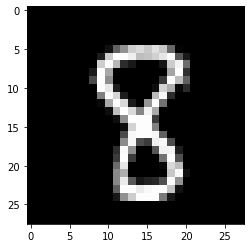

In [183]:
plt.imshow(xb[1].view(28, 28))
yb[1]

In [184]:
# Putting the DataLoader to the test
model, optimizer = get_model()

In [185]:
# Creating a fit() method based on the latest training loop
def fit():
    for epoch in range(epochs):
        for xb, yb in train_dl:
            pred = model(xb)
            loss = loss_f(pred, yb)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

In [186]:
fit()

In [187]:
loss, acc = loss_f(model(xb), yb), accuracy(model(xb), yb)
assert acc>0.7
loss, acc

(tensor(0.1023, grad_fn=<NllLossBackward>), tensor(0.9844))

### Random Sampling for the Training Set

Training sets need to be in random order which differs for each iteration.

**This does not apply to validation sets!!**

In [188]:
class Sampler():
    def __init__(self, ds, bs, shuffle=False):
        self.n, self.bs, self.shuffle = len(ds), bs, shuffle
        
    def __iter__(self):
        self.idxs = torch.randperm(self.n) if self.shuffle else torch.arange(self.n)
        for i in range(0, self.n, self.bs): 
            yield self.idxs[i:i+self.bs]

In [189]:
# Creating a small batch to test the sampler
small_ds = Dataset(*train_ds[:10])

In [190]:
# Without shuffling
s = Sampler(small_ds, 3, False)
[o for o in s]

[tensor([0, 1, 2]), tensor([3, 4, 5]), tensor([6, 7, 8]), tensor([9])]

In [191]:
# With shuffling
s = Sampler(small_ds, 3, True)
[o for o in s]

[tensor([0, 4, 7]), tensor([3, 8, 6]), tensor([1, 5, 9]), tensor([2])]

In [192]:
# Create collate() method
def collate(b):
    xs, ys = zip(*b)
    return torch.stack(xs), torch.stack(ys)

class DataLoader():
    def __init__(self, ds, sampler, collate_fn=collate):
        self.ds, self.sampler, self.collate_fn = ds, sampler, collate_fn
        
    def __iter__(self):
        for s in self.sampler:
            yield self.collate_fn([self.ds[i] for i in s]) # This yield, coupled with the co-routine in the sampler is an
                                                           # example of stream processing.

In [193]:
train_samp = Sampler(train_ds, bs, shuffle=True)
valid_samp = Sampler(valid_ds, bs, shuffle=False)

In [194]:
train_dl = DataLoader(train_ds, sampler=train_samp, collate_fn=collate)
valid_dl = DataLoader(valid_ds, sampler=valid_samp, collate_fn=collate)

tensor(8)

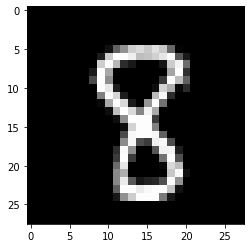

In [195]:
xb, yb = next(iter(valid_dl))
plt.imshow(xb[1].view(28, 28))
yb[1]

tensor(8)

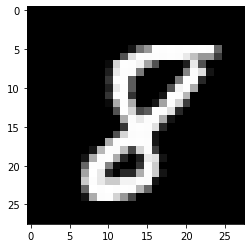

In [196]:
# Since the training set is shuffled, re-running this cell will generate a different
# output each time
xb, yb = next(iter(train_dl))
plt.imshow(xb[1].view(28, 28))
yb[1]

In [197]:
xb, yb = next(iter(train_dl))

In [198]:
# Creating model and optimizer
model, opt = get_model()
fit()

**Debug since this cell generates an assertion error**

In [199]:
loss, acc = loss_f(model(xb), yb), accuracy(model(xb), yb)
#assert acc > 0.7
loss, acc

(tensor(2.3007, grad_fn=<NllLossBackward>), tensor(0.1250))

### Using PyTorch's Data Loader

As always, PyTorch's implementations are highly optimized and come with all the bells and whistles.

In [200]:
from torch.utils.data import DataLoader, SequentialSampler, RandomSampler

In [201]:
train_dl = DataLoader(train_ds, bs, sampler=RandomSampler(train_ds), collate_fn=collate)
valid_dl = DataLoader(valid_ds, bs, sampler=SequentialSampler(valid_ds), collate_fn=collate)

In [202]:
model, optimizer = get_model()
fit()

In [203]:
loss_f(model(xb), yb), accuracy(model(xb), yb)

(tensor(0.0409, grad_fn=<NllLossBackward>), tensor(0.9844))

Additionally, we can set the parameter `drop_last` to True, and it will drop the last incomplete batch.

In [204]:
train_dl = DataLoader(train_ds, bs, shuffle=True, drop_last=True)
valid_dl = DataLoader(valid_ds, bs, shuffle=False)

In [205]:
model, optimizer = get_model()
fit()

loss, acc = loss_f(model(xb), yb), accuracy(model(xb), yb)

In [206]:
assert acc>0.7
loss, acc

(tensor(0.0518, grad_fn=<NllLossBackward>), tensor(0.9844))

### Validation

Validation loss will be printed at the end of each epoch.

Also, we always call `model.train()` before training and `model.eval()` before inference, because these are used by layers such as `nn.BatchNorm2d` and `nn.Dropout` to ensure appropriate behaviour.

In [207]:
def fit(epochs, model, loss_f, optimizer, train_dl, valid_dl):
    for epoch in range(epochs):
        #Handle batchnorm and dropout
        model.train()
        #print(model.training)
        for xb, yb in train_dl:
            loss = loss_f(model(xb), yb)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
        # Evaluation phase    
        model.eval()
        #print(model.training)
        with torch.no_grad():
            tot_loss, tot_acc = 0., 0.
            for xb, yb in valid_dl:
                pred = model(xb)
                tot_loss += loss_f(pred, yb)
                tot_acc += accuracy(pred, yb)
        nv = len(valid_dl)
        print(epoch, tot_loss/nv, tot_acc/nv)
    return tot_loss/nv, tot_acc/nv
            

**`NOTE` Most libraries don't have in-cuilt contingencies for different batch sizes and how they're supposed to be implemented in the fit() function above.**

This will be dealt with in a separate notebook.

In [208]:
# The function get_dls() returns dataloaders for the training and validation sets

def get_dls(train_ds, valid_ds, bs, **kwargs):
    return (DataLoader(train_ds, batch_size=bs, shuffle=True, **kwargs),
            DataLoader(valid_ds, batch_size=bs*2, **kwargs))

In [209]:
train_dl, valid_dl = get_dls(train_ds, valid_ds, bs)
model, optimizer = get_model()
loss, accuracy = fit(5, model, loss_f, optimizer, train_dl, valid_dl)

0 tensor(0.1998) tensor(0.9384)
1 tensor(0.1249) tensor(0.9621)
2 tensor(0.4389) tensor(0.8935)
3 tensor(0.0981) tensor(0.9703)
4 tensor(0.1030) tensor(0.9696)
